In [1]:
import matplotlib

import torch
import torch.nn as nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
import seaborn as sns
import scipy
import joblib

import gc

from IPython.display import clear_output

from functools import partial
from tqdm.notebook import tqdm
from sconf import Config

import sys

sys.path.append("..")

from classes import MLP, MultiTaskLoss
from utils import non_markovian_midprice, generate_time_one_time_two

/Users/nicholasmartin/Programming/Research/optimal-execution-kernel-decomposition/venv/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
font = {'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
config = Config("config.yaml")

In [4]:
rng = np.random.default_rng(123)
torch.manual_seed(123)

num_timesteps = 1_000
final_time = 1
initial_price = 1
decomp_dim = 2
num_episodes = 5_000
kernel_batch_size = 256

dt = final_time / num_timesteps

# kernel_function = lambda x,y: ((np.abs((x-y))+(dt))**(0.51-1))/scipy.special.gamma(0.51)
# kernel_function = lambda x, y: np.exp(-((x - y) ** 2) / (0.1))
# kernel_function = lambda x,y: np.exp(-np.abs((x-y)))
kernel_function = lambda x, y: 1 / (1 + np.abs(x - y) ** 0.5)
# kernel_function = lambda x, y: (1 + (np.abs(x - y) ** 2)) ** (-0.5)
K0 = kernel_function(0, 0)

# Generate Data

# NN Approach

In [5]:
learning_rate = 1e-4
network = MLP(decomp_dim=decomp_dim, learn_price_impact=True)

optimizer = torch.optim.Adam(params=network.kernel_func.parameters(), lr=learning_rate)

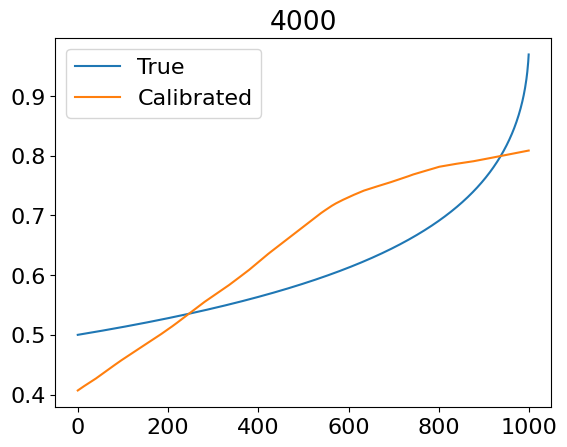

In [6]:
loss_list = []
for i in tqdm(range(num_episodes)):

    # time_one = torch.FloatTensor([num_timesteps]).reshape(-1, 1) * dt
    time_one = (
        torch.FloatTensor([rng.uniform(0, num_timesteps)]).reshape(-1, 1) * dt
    )
    time_two = torch.FloatTensor([rng.uniform(0, num_timesteps)]).reshape(-1, 1) * dt

    K_one_two = network.approx_func(time_one, time_two).flatten()
    K_one_one = network.approx_func(time_one, time_one).flatten()

    true_val = torch.FloatTensor(
        kernel_function(time_one.detach().numpy(), time_two.detach().numpy())
    ).flatten()

    true_error = torch.abs(true_val - K_one_two)
    one_error = torch.abs(K0 - K_one_one)

    delta = torch.FloatTensor(
        rng.uniform(-num_timesteps, num_timesteps, (kernel_batch_size, 1))
    )
    K_one_two_delta = network.approx_func(time_one + delta, time_one + delta).flatten()
    translation_error = torch.abs(K_one_two - K_one_two_delta)

    loss_tensor = torch.hstack(
        [
            (true_error**2).mean(),
            # (one_error**2).mean(),
            # (translation_error**2).mean()
        ]
    )

    loss = loss_tensor.mean()

    loss_list.append(loss.detach().item())

    network.zero_grad()
    optimizer.zero_grad()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(network.kernel_func.parameters(), 1)
    optimizer.step()

    network.zero_grad()
    optimizer.zero_grad()

    if i % 1000 == 0:
        clear_output(wait=True)
        s = 1
        s_val = num_timesteps * s
        kernel_plot = []
        kernel_plot_two = []

        for _ in range(0, int(s_val)):
            k_s_t = network.approx_func(
                torch.FloatTensor([s_val * dt]).reshape(-1, 1),
                torch.FloatTensor([_ * dt]).reshape(1, -1),
            )
            kernel_plot.append(k_s_t.detach().item())

        for _ in range(0, int(s_val)):
            val = kernel_function(_ * dt, s_val * dt)
            kernel_plot_two.append(val)

        plt.title(i)
        plt.plot(kernel_plot_two, label="True")
        plt.plot(kernel_plot, label="Calibrated")
        plt.legend()
        plt.show()

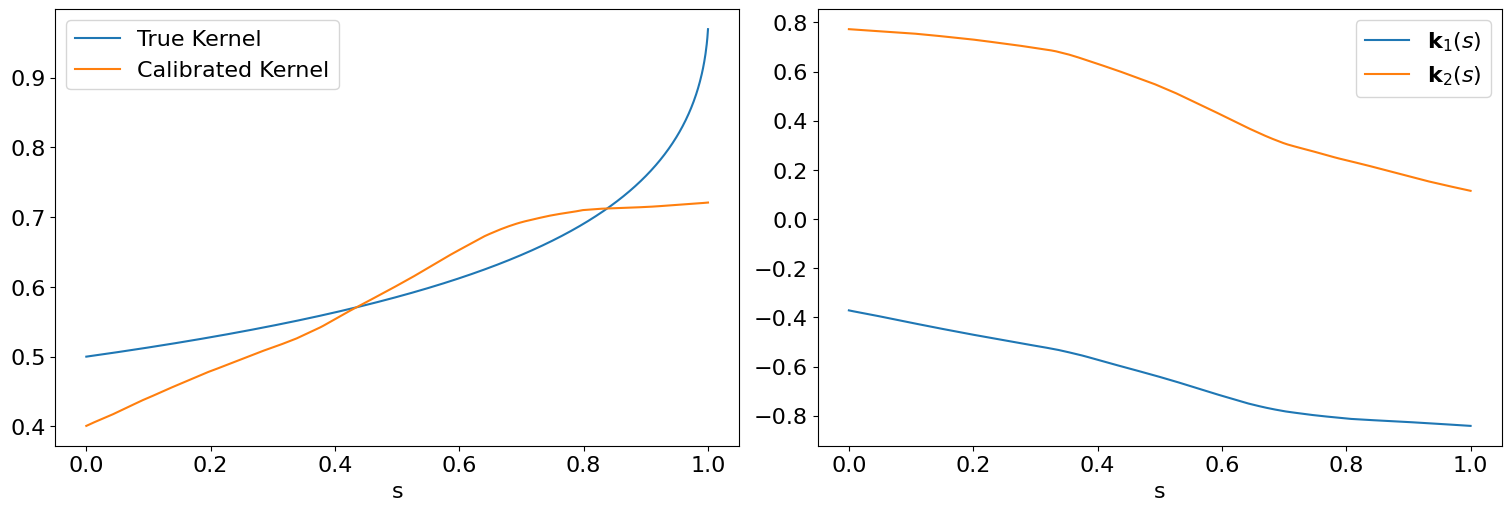

In [7]:
s_val = 1
final_timesteps = int(num_timesteps * s_val)
kernel_plot = []
learnt_kernel_plot = []
true_kernel_plot = []
derivative_plot = []        

for i in range(0, final_timesteps):

    k_s_t = network.approx_func(
        torch.FloatTensor([final_timesteps * dt]).reshape(-1, 1),
        torch.FloatTensor([i * dt]).reshape(1, -1),
    )
    learnt_kernel_plot.append(k_s_t.detach().item())

    k_s_t = kernel_function(final_timesteps * dt, i * dt)
    true_kernel_plot.append(k_s_t)

    kernel_val = network(torch.FloatTensor([i * dt]))
    kernel_plot.append(kernel_val.detach().numpy())

    time = torch.FloatTensor([i * dt])
    kernel_deriv = torch.autograd.functional.jacobian(network, time).flatten()

    derivative_plot.append(kernel_deriv.detach().numpy())

fig, ax  = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)

derivative_plot = np.vstack(derivative_plot)
kernel_plot = np.vstack(kernel_plot)

ax[0].plot(np.linspace(0,1, len(true_kernel_plot)), true_kernel_plot, label=r'True Kernel')
ax[0].plot(np.linspace(0,1, len(learnt_kernel_plot)), learnt_kernel_plot, label=r'Calibrated Kernel')

ax[1].plot(np.linspace(0,1, len(kernel_plot)), kernel_plot[:, 0], label=r"$\mathbf{k}_{1}(s)$")
ax[1].plot(np.linspace(0,1, len(kernel_plot)), kernel_plot[:, 1], label=r"$\mathbf{k}_{2}(s)$")

ax[0].set_xlabel('s')
ax[1].set_xlabel('s')

ax[0].legend()
ax[1].legend()

# plt.savefig('../figures/fractional_decomposition.pdf')
plt.show()

# Solving HJB Equation

In [8]:
num_timesteps = 10_000
final_time = 1
dt = final_time/num_timesteps
timesteps = np.arange(0, final_time+dt, dt)

network.eval()

s_val = 1
final_timesteps = int(num_timesteps * s_val)
kernel_plot = []
derivative_plot = []        

for i in range(0, final_timesteps):

    kernel_val = network(torch.FloatTensor([i * dt]))
    kernel_plot.append(kernel_val.detach().numpy())

    time = torch.FloatTensor([i * dt])
    kernel_deriv = torch.autograd.functional.jacobian(network, time).flatten()

    derivative_plot.append(kernel_deriv.detach().numpy())

k_t_plus_one = np.vstack(kernel_plot).astype('float32')
k_t_plus_one_prime = np.array(derivative_plot).astype('float32')

del kernel_plot, derivative_plot
del network, optimizer

gc.collect()

11539

In [9]:
def h_t(h_t_plus_one, delta_t_h, dt):

    h_t = h_t_plus_one - delta_t_h * dt

    return h_t

def k_dot_G_q(G_grid_base, k_t_plus_one_prime, q):

    k_dot = k_t_plus_one_prime
    
    k_dot_G_one = (k_dot[0] * G_grid_base).reshape(1, -1)
    k_dot_G_two = (k_dot[1] * G_grid_base).reshape(1, -1)

    k_dot_G = k_dot_G_one + k_dot_G_two
    
    return_val = np.outer(k_dot_G, q).reshape(1, G_grid_base.shape[0], q.shape[0])

    return return_val


def phi_q_squared(phi, q):

    return phi * (q**2)

def partial_h_q(h_t_plus_one, dq):

    delta_h_q = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[:, :, 1:-1] - h_t_plus_one[:, :, 0:-2]

    delta_h_q[:, :, 1:-1] = middle / (dq)

    h_q_lower = 2 * h_t_plus_one[:, :, 0] - h_t_plus_one[:, :, 1]
    delta_h_q_lower = h_t_plus_one[:, :, 0] - h_q_lower

    h_q_upper = 2 * h_t_plus_one[:, :, -1] - h_t_plus_one[:, :, -2]
    delta_q_upper = h_q_upper - h_t_plus_one[:, :, -1]

    delta_h_q[:, :, 0] = delta_h_q_lower / (dq)
    delta_h_q[:, :, -1] = delta_q_upper / (dq)

    return delta_h_q

def partial_h_G_one(h_t_plus_one, dG):

    delta_h_G = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[1:-1, :, :] - h_t_plus_one[0:-2, :, :]

    delta_h_G[1:-1, :, :] = middle / dG

    h_G_lower = 2 * h_t_plus_one[0, :, :] - h_t_plus_one[1, :, :]
    delta_h_G_lower = h_t_plus_one[0, :, :] - h_G_lower

    h_G_upper = 2 * h_t_plus_one[-1, :, :] - h_t_plus_one[-2, :, :]
    delta_h_G_upper = h_G_upper - h_t_plus_one[-1, :, :]

    delta_h_G[0, :, :] = delta_h_G_lower / dG
    delta_h_G[-1, :, :] = delta_h_G_upper / dG

    return delta_h_G

def partial_h_G_two(h_t_plus_one, dG):

    delta_h_G = np.zeros_like(h_t_plus_one)

    middle = h_t_plus_one[:, 1:-1, :] - h_t_plus_one[:, 0:-2, :]

    delta_h_G[:, 1:-1, :] = middle / dG

    h_G_lower = 2 * h_t_plus_one[:, 0, :] - h_t_plus_one[:, 1, :]
    delta_h_G_lower = h_t_plus_one[:, 0, :] - h_G_lower

    h_G_upper = 2 * h_t_plus_one[:, -1, :] - h_t_plus_one[:, -2, :]
    delta_h_G_upper = h_G_upper - h_t_plus_one[:, -1, :]

    delta_h_G[:, 0, :] = delta_h_G_lower / dG
    delta_h_G[:, -1, :] = delta_h_G_upper / dG

    return delta_h_G

def y(h_t_plus_one, q, k_t_plus_one, b, kappa, dq, dG):

    term_one = b * q.reshape(1, -1)

    delta_h_G_one = partial_h_G_one(h_t_plus_one=h_t_plus_one, dG=dG)
    delta_h_G_two = partial_h_G_two(h_t_plus_one=h_t_plus_one, dG=dG)
    delta_h_q = partial_h_q(h_t_plus_one=h_t_plus_one, dq=dq)

    term_three = delta_h_q

    term_four = term_three + term_one

    term_two = b * ((k_t_plus_one[0] * delta_h_G_one) + (k_t_plus_one[1] * delta_h_G_two))

    return -(term_four+term_two)

def xi(a, kappa):

    return (a * kappa) / (((1 + a) * kappa) ** (1 + 1 / a))

def F_star(xi, y, a):

    return xi * (y ** (1 + 1 / a))

def F_star_term(h_t_plus_one, q, k_t_plus_one, a, b, kappa, dq, dG):

    y_term = y(
        h_t_plus_one=h_t_plus_one, q=q, kappa=kappa, k_t_plus_one=k_t_plus_one, b=b, dq=dq, dG=dG
    )

    xi_term = xi(a=a, kappa=kappa)

    F_star_term_var = F_star(xi=xi_term, y=y_term, a=a)

    return F_star_term_var

def rhs(h_t_plus_one, q, G_grid_base, k_t_plus_one, k_t_plus_one_prime, phi, a, b, kappa, dq, dG):

    k_dot_G_q_term = k_dot_G_q(
        G_grid_base=G_grid_base, k_t_plus_one_prime=k_t_plus_one_prime, q=q
    )

    phi_q_squared_term = phi_q_squared(phi=phi, q=q)

    f_star_term = F_star_term(
        h_t_plus_one=h_t_plus_one,
        q=q,
        k_t_plus_one=k_t_plus_one,
        a=a,
        b=b,
        kappa=kappa,
        dq=dq,
        dG=dG,
    )

    return k_dot_G_q_term + phi_q_squared_term.reshape(1, 1, -1) - f_star_term

# Solve equation

In [10]:
q_val_dict = {}

a_vals = (0.8, 1.0, 1.2)[::-1]

for a in a_vals:
    kappa = 0.0001
    b = 0.0001
    phi = 10 * kappa
    alpha = 100 * kappa

    G_lower = -b*0.1
    G_upper = b*0.1
    num_G_steps = 10
    dG = G_upper/num_G_steps
    G_grid_base = np.arange(G_lower-dG, G_upper+dG, dG, dtype='float32')
    G_grid = np.tile(G_grid_base, (len(G_grid_base), 1))

    q_lower = 0
    q_upper = 1
    num_q_steps = 50
    dq = q_upper/num_q_steps
    q_grid = np.arange(q_lower, q_upper+dq, dq, dtype='float32')

    # [time, G, G, q]
    h_grid = np.zeros((num_timesteps, G_grid.shape[1], G_grid.shape[1], len(q_grid)), dtype='float32')
    nu_star = np.zeros((num_timesteps, len(G_grid), len(G_grid), len(q_grid)), dtype='float32')

    # Initialize terminal condition
    h_grid[-1, :, :, :] = -alpha * (q_grid**2)

    for i in range(1, num_timesteps):

        if i % 1000 == 1:
            clear_output(wait=True)
            print(int(100*(i/num_timesteps)))
            print(i/num_timesteps)

            if np.isnan(h_grid).sum()>1:
                break

        time = (num_timesteps - i) * dt

        k_t_plus_one_val = k_t_plus_one[num_timesteps - i] 
        k_t_plus_one_prime_val = k_t_plus_one_prime[num_timesteps - i]

        h_t_plus_one = h_grid[num_timesteps - i]

        delta_t_h = rhs(
            h_t_plus_one=h_t_plus_one,
            q=q_grid,
            k_t_plus_one=k_t_plus_one_val,
            k_t_plus_one_prime = k_t_plus_one_prime_val,
            G_grid_base=G_grid_base,
            a=a,
            b=b,
            kappa=kappa,
            phi=phi,
            dq=dq,
            dG=dG,
        )

        h_t_term = h_t_plus_one - delta_t_h*dt

        h_grid[num_timesteps - (i + 1)] = h_t_term

        y_term = y(
            h_t_plus_one=h_t_plus_one,
            q=q_grid,
            k_t_plus_one=k_t_plus_one_val,
            b=b,
            kappa=kappa,
            dq=dq,
            dG=dG,
        )

        nu_star[num_timesteps - (i + 1)] = ((y_term) / ((1 + a) * kappa)) ** (1 / a)

        if i % 1_000 == 1:
            gc.collect()

    Q = np.ones(num_timesteps)
    for i in range(0, num_timesteps - 1):

        q_index = np.argmin(np.abs(Q[i] - q_grid))

        dQ = - nu_star[i, int(num_G_steps/2), int(num_G_steps/2), q_index] * dt

        new_term = Q[i] + dQ

        Q[i + 1] = new_term

    q_val_dict[int(a*100)] = Q

90
0.9001


In [11]:
q_val_dict['dt'] = dt

In [23]:
joblib.dump(q_val_dict, '../results/OE_with_fractional.joblib')

['../results/OE_with_fractional.joblib']

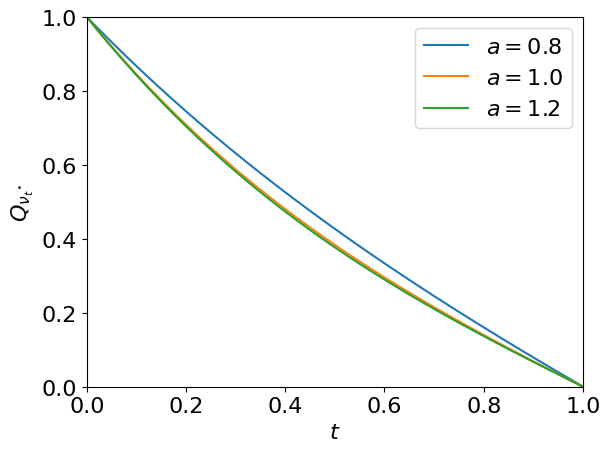

In [22]:
for key in sorted([_ for _ in q_val_dict.keys() if type(_)==int]):
    Q = q_val_dict[key]
    plt.plot(np.linspace(0,1, len(Q[Q>0])), Q[Q>0], label=rf'$a={key/100}$')

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$Q_{{\nu_t}^{\star}}$')
plt.xlabel(r'$t$')
plt.legend()
plt.savefig('../figures/fractional_quantity.pdf')
plt.show()

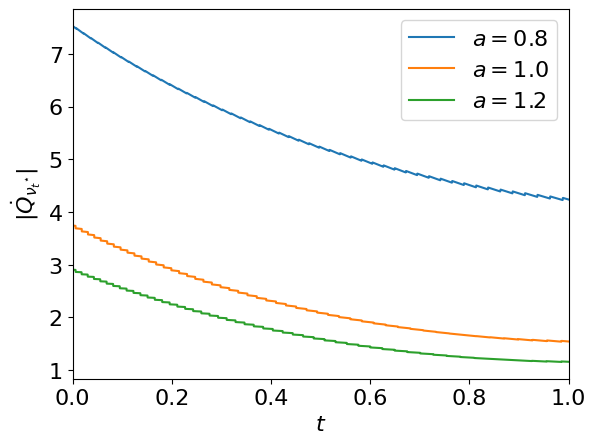

In [21]:
for key in sorted([_ for _ in q_val_dict.keys() if type(_)==int]):
    Q = q_val_dict[key]
    plt.plot(np.linspace(0,1, len(Q[Q>0])-1), np.abs(np.diff(Q[Q>0])/dt), label=rf'$a={key/100}$')

# plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$|\dot{Q}_{{\nu_t}^{\star}}$|')
plt.xlabel(r'$t$')
plt.legend()
plt.savefig('../figures/fractional_optimal_trading_speed.pdf')
plt.show()

In [15]:
Q_one= np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_one[i] - q_grid))

    dQ = - nu_star[i, -1, -1, q_index] * dt

    new_term = Q_one[i] + dQ

    Q_one[i + 1] = new_term

Q_two = np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_two[i] - q_grid))

    dQ = - nu_star[i, 0, 0, q_index] * dt

    new_term = Q_two[i] + dQ

    Q_two[i + 1] = new_term

Q_three = np.ones(num_timesteps)
for i in range(0, num_timesteps - 1):

    q_index = np.argmin(np.abs(Q_three[i] - q_grid))

    dQ = - nu_star[i, int(num_G_steps/2), int(num_G_steps/2), q_index] * dt

    new_term = Q_three[i] + dQ

    Q_three[i + 1] = new_term

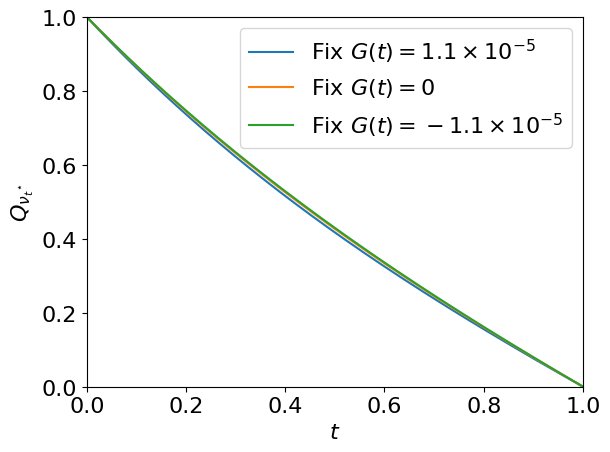

In [19]:
# plt.plot(Q_one, label=r'Fix $G(t)=1.1b$')
plt.plot(np.linspace(0,1, len(Q_one[Q_one>0])),
         Q_one[Q_one>0], 
         label=r'Fix $G(t)=1.1 \times 10^{-5}$')

# plt.plot(Q_three, label=r'Fix $G(t)=0$')
plt.plot(np.linspace(0,1, len(Q_three[Q_three>0])),
         Q_three[Q_three>0], 
         label=r'Fix $G(t)=0$')

# plt.plot(Q_two, label=r'Fix $G(t)=-1.1b$')
plt.plot(np.linspace(0,1, len(Q_two[Q_two>0])),
         Q_two[Q_two>0], 
         label=r'Fix $G(t)=-1.1 \times 10^{-5}$')

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$Q_{{\nu_t}^{\star}}$')
plt.xlabel(r'$t$')
plt.legend()
plt.savefig('../figures/fractional_multiple_G_hjb.pdf')
plt.show()

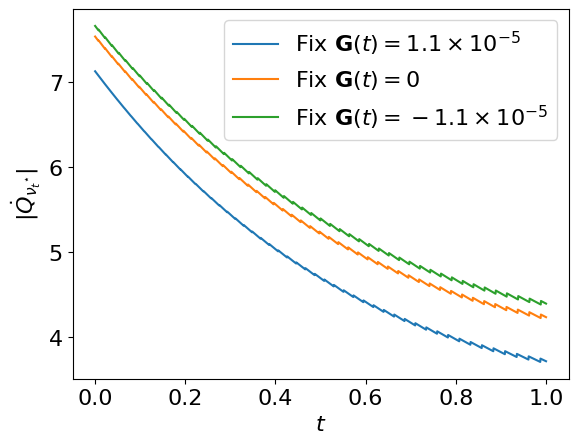

In [20]:
# plt.plot(Q_one, label=r'Fix $G(t)=1.1b$')
plt.plot(np.linspace(0,1, len(Q_one[Q_one>0])-1),
         np.abs(np.diff(Q_one[Q_one>0])/dt), 
         label=r'Fix $\mathbf{G}(t)=1.1 \times 10^{-5}$')

# plt.plot(Q_three, label=r'Fix $G(t)=0$')
plt.plot(np.linspace(0,1, len(Q_three[Q_three>0])-1),
         np.abs(np.diff(Q_three[Q_three>0])/dt), 
         label=r'Fix $\mathbf{G}(t)=0$')

# plt.plot(Q_two, label=r'Fix $G(t)=-1.1b$')
plt.plot(np.linspace(0,1, len(Q_two[Q_two>0])-1),
         np.abs(np.diff(Q_two[Q_two>0])/dt), 
         label=r'Fix $\mathbf{G}(t)=-1.1 \times 10^{-5}$')

# plt.ylim(0, 1)
# plt.xlim(0, 1)
plt.legend()
plt.ylabel(r'$|\dot{Q}_{{\nu_t}^{\star}}|$')
plt.xlabel(r'$t$')
plt.legend()
plt.savefig('../figures/fractional_trading_speed_multiple_G_hjb.pdf')
plt.show()